In [ ]:
!pip install ultralytics facenet-pytorch pillow-heif

In [ ]:
from facenet_pytorch import InceptionResnetV1
from ultralytics import YOLO
import torch
from PIL import Image
import numpy as np
import os
from pillow_heif import register_heif_opener

register_heif_opener()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Loading YOLOv8...")
yolo = YOLO("yolov8n.pt")
yolo.to(device)

print("Loading FaceNet...")
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

print(f"✅ Models loaded on {device}.")

def get_embedding(image_path):
    try:
        # 1. Load Image
        img = Image.open(image_path).convert('RGB')

        # 2. Detect Face using YOLO
        results = yolo(img, verbose=False)
        boxes = results[0].boxes.xyxy.cpu().numpy()

        if len(boxes) == 0:
            return None # No face found

        # 3. Crop the first face
        x1, y1, x2, y2 = map(int, boxes[0])
        face = img.crop((x1, y1, x2, y2))

        # 4. Preprocess for FaceNet (Resize to 160x160)
        face = face.resize((160, 160))

        # 5. Convert to Tensor & Normalize
        face_tensor = torch.tensor(np.array(face)).permute(2, 0, 1).float().to(device)
        face_tensor = (face_tensor - 127.5) / 128.0
        face_tensor = face_tensor.unsqueeze(0)

        # 6. Generate Embedding
        embedding = resnet(face_tensor).detach().cpu().numpy()[0]
        return embedding
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return None

print("\nEnrolling faces...")

people_database = {
    "Mint": [
        "mint1.HEIC", "mint2.HEIC", "mint3.HEIC", "mint4.HEIC", "mint5.HEIC",
        "mint6.JPG", "mint7.HEIC", "mint8.HEIC", "mint9.HEIC", "mint10.HEIC"
    ],
    "Angie": [
        "angie1.HEIC", "angie2.JPG", "angie3.JPG"
    ],
    "Toon": [
        "toon1.HEIC", "toon2.jpg", "toon3.JPG"
    ],
    "Nine": [
        "nine1.JPG","nine2.JPG","nine3.JPG"
    ],
    "Bonus": [
        "bonus1.HEIC"
    ],
    "Been": [
        "been1.HEIC"
    ]
}

known_embeddings = []
known_names = []

for name, photos in people_database.items():
    for photo in photos:
        if not os.path.exists(photo):
            print(f"⚠️ Skipped '{photo}' (File not found - check spelling/case!)")
            continue

        emb = get_embedding(photo)
        if emb is not None:
            known_embeddings.append(emb)
            known_names.append(name)
            print(f"  ✅ Enrolled {name} from {photo}")
        else:
            print(f"  ❌ No face detected in {photo}")

print(f"\nFinished! Total faces enrolled: {len(known_embeddings)}")

Loading YOLOv8...
Loading FaceNet...
✅ Models loaded on cuda.

Enrolling faces...
  ✅ Enrolled Mint from mint1.HEIC
  ✅ Enrolled Mint from mint2.HEIC
  ✅ Enrolled Mint from mint3.HEIC
  ✅ Enrolled Mint from mint4.HEIC
  ✅ Enrolled Mint from mint5.HEIC
  ✅ Enrolled Mint from mint6.JPG
  ✅ Enrolled Mint from mint7.HEIC
  ✅ Enrolled Mint from mint8.HEIC
  ✅ Enrolled Mint from mint9.HEIC
  ✅ Enrolled Mint from mint10.HEIC
  ✅ Enrolled Angie from angie1.HEIC
  ✅ Enrolled Angie from angie2.JPG
  ✅ Enrolled Angie from angie3.JPG
  ✅ Enrolled Toon from toon1.HEIC
  ✅ Enrolled Toon from toon2.jpg
  ✅ Enrolled Toon from toon3.JPG
  ✅ Enrolled Nine from nine1.JPG
  ✅ Enrolled Nine from nine2.JPG
  ✅ Enrolled Nine from nine3.JPG
  ✅ Enrolled Bonus from bonus1.HEIC
  ✅ Enrolled Been from been1.HEIC

Finished! Total faces enrolled: 21


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture button to be clicked
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

--- 🔒 FACE SECURITY SYSTEM ACTIVE ---
Click 'Capture' to request access...


<IPython.core.display.Javascript object>

✅ ACCESS GRANTED: Mint


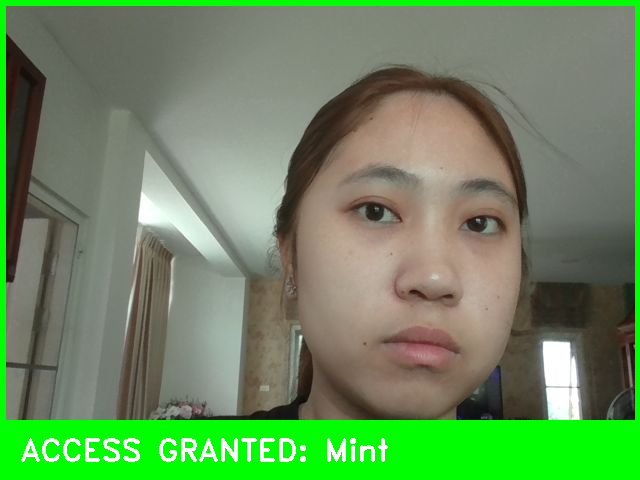

Timestamp: 05:39:02


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from datetime import datetime

# --- 🔒 SECURITY CONFIGURATION ---
# List the exact names of people allowed to enter
AUTHORIZED_USERS = ["Mint", "Angie", "Toon", "Nine", "Bonus"]

# How strict the matcher should be (0.6 is standard, 0.5 is stricter)
TOLERANCE = 0.9
# ---------------------------------

if len(known_embeddings) == 0:
    print("ERROR: No faces enrolled! Run Cell 3.")
else:
    try:
        print("--- 🔒 FACE SECURITY SYSTEM ACTIVE ---")
        print("Click 'Capture' to request access...")
        image_file = take_photo()

        # 1. Get Embedding
        unknown_emb = get_embedding(image_file)
        image = cv2.imread(image_file)

        if unknown_emb is None:
            print("❌ No face detected. Please stand in front of the camera.")
            cv2_imshow(image)
        else:
            # 2. Compare with Database
            identity = "Unknown"
            best_score = 100 # Start high (lower is better for distance)

            for i, known_emb in enumerate(known_embeddings):
                # Calculate distance (Lower = Better Match)
                # We use Euclidean distance for FaceNet (standard method)
                dist = np.linalg.norm(unknown_emb - known_emb)

                if dist < best_score:
                    best_score = dist
                    if dist < TOLERANCE:
                        identity = known_names[i]

            # 3. DECIDE: Access Granted or Denied?
            # We calculate the confidence as specific percentage for display
            confidence = max(0, (1.0 - best_score)) * 100

            if identity in AUTHORIZED_USERS:
                # --- GRANT ACCESS ---
                status_text = f"ACCESS GRANTED: {identity}"
                color = (0, 255, 0) # Green
                print(f"✅ {status_text}")

                # Draw fancy green border
                h, w, _ = image.shape
                cv2.rectangle(image, (0,0), (w, h), (0, 255, 0), 10)

            else:
                # --- DENY ACCESS ---
                status_text = "ACCESS DENIED"
                color = (0, 0, 255) # Red
                print(f"🚫 {status_text} (Unknown Person)")

                # Draw warning red border
                h, w, _ = image.shape
                cv2.rectangle(image, (0,0), (w, h), (0, 0, 255), 10)

            # 4. Draw the Box and Label on the face
            # We assume the main face is the one we recognized
            # (Ideally, we would save the box coordinates from get_embedding,
            # but for simplicity, we will just draw the status text clearly)

            # Add a background bar for the text so it's readable
            cv2.rectangle(image, (0, h-60), (w, h), color, cv2.FILLED)
            cv2.putText(image, status_text, (20, h-20),
                        cv2.FONT_HERSHEY_DUPLEX, 1.0, (255, 255, 255), 2)

            # Show the final security feed
            cv2_imshow(image)

            # Log the entry time
            now = datetime.now().strftime("%H:%M:%S")
            print(f"Timestamp: {now}")

        # Clean up
        !rm photo.jpg

    except Exception as e:
        print(f"System Error: {e}")